# Classifying values as anomalous

Sometimes we’re happy with the type that ptype infers for a column, but discover that it has incorrectly treated some values. We consider two scenarios. First, we discuss an example where ptype treats some known anomalous values as legitimate. We can remedy this issue by extending the set of values that ptype treats as anomalies, and then rerunning the analysis. We illustrate this with a toy example.

Secondly, we discuss an example where some known legitimate values are treated as anomalies. We demonstrate how the user can handle such cases by modifying the set of characters supported by the string PFSM so that legitimate values with unsupported characters are considered to be valid rather than anomalous.

In [1]:
# Preamble to run notebook in context of source package.
# NBVAL_IGNORE_OUTPUT
import sys
sys.path.insert(0, '../')

# Anomalous values treated as legitimate

In [2]:
import pandas as pd

x = ['Jack', 'Joe', 'James', 'error']
column = 'name'

df = pd.DataFrame(x, dtype='str', columns=[column])
df

,name
0,Jack
1,Joe
2,James
3,error


In [3]:
from ptype.Ptype import Ptype

ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,name
type,string
normal values,"[Jack, James, Joe, error]"
missing values,[]
anomalous values,[]


In [4]:
an_values = ptype.get_additional_an_values()

an_values.extend(["error"])
ptype.set_additional_an_values(an_values)

schema = ptype.schema_fit(df)
schema.show()

,name
type,string
normal values,"[Jack, James, Joe]"
missing values,[]
anomalous values,[error]


# Legitimate values treated as anomalous

For this use-case, we use the Kaggle ML & DS Survey to plot the histogram of favourite programming languages. Note that , which we obtain the dataset from https://www.kaggle.com/kaggle/kaggle-survey-2017.

We begin by loading the data into a Pandas DataFrame:

In [5]:
import pandas as pd
from ptype.Ptype import Ptype

df = pd.read_csv("../data/ml_ds_survey.csv", encoding="ISO-8859-1", dtype=str, keep_default_na=False)
df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",,NA,Employed full-time,,,Yes,,DBA/Database Engineer,Fine,...,,,,,,,,,,
1,Female,United States,30,"Not employed, but looking for work",,,,,,,...,,,,,,,,Somewhat important,,
2,Male,Canada,28,"Not employed, but looking for work",,,,,,,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56,"Independent contractor, freelancer, or self-em...",,,Yes,,Operations Research Practitioner,Poorly,...,,,,,,,,,,
4,Male,Taiwan,38,Employed full-time,,,Yes,,Computer Scientist,Fine,...,,,,,,,,,,


By inspecting the data and meta-data, we notice that the "LanguageRecommendationSelect" is used to record the programming language data scientists suggest. 

In [6]:
column = "LanguageRecommendationSelect"
df = df[[column]]
df

,LanguageRecommendationSelect
0,F#
1,Python
2,R
3,Python
4,Python
...,...
16711,
16712,Python
16713,
16714,


We analyze the dataset using ptype:

In [7]:
ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,LanguageRecommendationSelect
type,string
normal values,"[Haskell, Java, Julia, Matlab, Other, Python, ..."
missing values,[ε]
anomalous values,"[C/C++/C#, F#]"
(empty string marker),ε


As we can see, ptype classifies the column as string and labels the data values of "C/C++/C#" and "F#" as anomalies. This occurs because the characters of "#", "+" and "/" are not recognized by the Probabilistic Finite-State Machine (PFSM) for the string type since they are excluded from the corresponding alphabet. We make this choice assuming that these characters are more likely to indicate an anomalous value than a valid data value.

Let us continue without interacting with ptype for the time being.

In [8]:
df2 = schema.transform(df)
df2

,LanguageRecommendationSelect
0,<NA>
1,Python
2,R
3,Python
4,Python
...,...
16711,<NA>
16712,Python
16713,<NA>
16714,<NA>


Note that this would lead to 311 data entries out of 16716 to be replaced by "pd.NA":

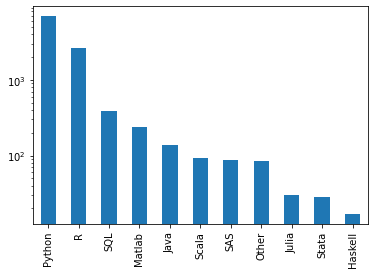

In [9]:
# NBVAL_IGNORE_OUTPUT
df2[column].value_counts().plot(kind='bar', logy=True)

Now, let us look at how we could have interacted with ptype to fix its predictions. One way to handle such cases is to modify the alphabet of the PFSM for the string type. We simply add the unsupported characters to the existing set of characters and re-run the inference.

In [10]:
str_alphabet = ptype.get_string_alphabet()

str_alphabet.extend(["#", "+", "/"])
ptype.set_string_alphabet(str_alphabet)

schema = ptype.schema_fit(df)
schema.show()
# to-do: should we consider making this column specific rather than a global list
# this again can be done similar to how it is handled in pandas.read_csv which is 
# keep_default_na=False, na_values={'species':['']}

,LanguageRecommendationSelect
type,string
normal values,"[C/C++/C#, F#, Haskell, Java, Julia, Matlab, O..."
missing values,[ε]
anomalous values,[]
(empty string marker),ε


We can then carry out the steps applied previously.

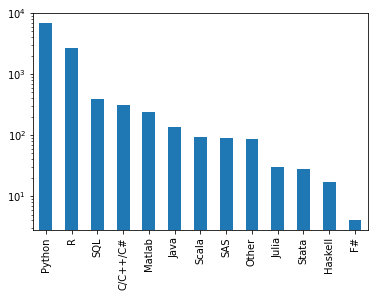

In [11]:
df2 = schema.transform(df)

# NBVAL_IGNORE_OUTPUT
df2[column].value_counts().plot(kind='bar', logy=True)

The plot confirms that the values of "C/C++/C#" and "F# are now taken into account.